In [2]:
from chainer import __version__
print(__version__)

1.5.0.2


In [3]:
"""Stack overflow question"""

'Stack overflow question'

For simplicity consider a linear control system:

$$\frac{d \mathbf{x}}{dt} =  W \, \mathbf{x} +  \mathbf{b}$$

where **`x`** is `M x 1` vector.
Our desired state is $\mathbf{x}_{desired}$ to be achieved in in `T` steps. Loss function:

$$||\mathbf{x}_{desired} - \mathbf{x}_T||_2^2$$



##Sandbox
Write down one step for the control equation and check how gradient w.r.t to parameters  is calculated

In [ ]:
from  chainer import Variable
import chainer.functions as F
import numpy as np

def V(x):
    return Variable(x.astype(np.float32))

N = 100
M = 2
dt = 0.01

x = V(np.random.randn(N,M))
x_desired = V(np.ones(N).reshape(-1,1) * np.r_[3,4])

"""Write down one step for the control equation and check how gradient w.r.t to parameters  is calculated"""
""" d**x**/dt =  W **x** + **b** """

lin_control = F.Linear(M, M, initialW=None, initial_bias=None)
#quadr_control = lambda x: x**2
def explicit_euler_dx(x):
    dx = lin_control(x) #+ quadr_control(x)
    return dx

xout = V(x.data)

for tt in range(100):
    xout += explicit_euler_dx(x) * dt
"""initial values"""
loss = (xout-x_desired)
loss.grad = np.ones( x.data.shape, dtype=np.float32)

loss.backward()

x.grad[:10]

## Set up a small chainer system

In [5]:
def explicit_euler_dx(x, handle):
    dx = handle(x)
    return dx

Update function:

In [6]:
from chainer import Chain

class MyChain(Chain):
    def __init__(self, M):
        super(MyChain, self).__init__(
            l1=F.Linear(M, M, initialW=None, initial_bias=None),
        )

    def __call__(self, x, T, dt):
        xout = V(x.data)
        for tt in range(T):
            xout += explicit_euler_dx(x, self.l1) * dt
        return xout

Loss function:

In [7]:
class Loss(Chain):
    def __init__(self, predictor):
        super(Loss, self).__init__(predictor=predictor)
        
    def __call__(self, x, x_desired, T ,dt):
        x_end = self.predictor(x, T, dt)
        #x_desired = V(np.ones(x_end.data.shape[0]).reshape(-1,1) * x_desired)
        self.loss = F.mean_squared_error(x_desired, x_end)
        return self.loss

In [12]:
N = 100
M = 2
T = 100

In [29]:
from chainer import optimizers
model = Loss(MyChain(M))
optimizer = optimizers.MomentumSGD(lr = 1e-3, momentum=0.9)
optimizer.setup(model)

In [20]:
x_desired = np.r_[3,4]
x_desired = V(np.ones(N).reshape(-1,1) * x_desired)

In [30]:
from tqdm import tqdm
nepochs = 100
dt = 0.01
losslist = []
for epoch in tqdm(range(nepochs)):
    #print('epoch %d' % epoch, end = "\t")
    x = V(0.01*np.random.randn(N,M))
    #model.zerograds()
    loss = model( x, x_desired, T, dt)
    losslist.append(loss.data)
    #print("loss", loss.data)
    loss.backward()
    optimizer.update(model, x, x_desired, T, dt)

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

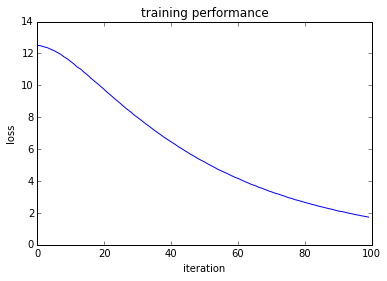

In [33]:
plt.plot(losslist)
plt.title("training performance")
plt.xlabel("iteration")
plt.ylabel("loss")

In [ ]:
print("optimal control parameters:")
print("W", "------------", model.children().__next__().l1.W.data, sep = "\n")
print("b", "------------",model.children().__next__().l1.b.data, sep = "\n")